In [28]:
import pandas as pd
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from sklearn.preprocessing import StandardScaler
import random

# Data Loading and Preprocessing

In [29]:
df = pd.read_csv("/content/DAYTON_hourly.csv")

In [30]:
def extract_hour(dt, fmt):
    dt_obj = datetime.strptime(dt, fmt)
    return dt_obj.time().hour

def extract_weekday(dt, fmt):
    dt_obj = datetime.strptime(dt, fmt)
    return dt_obj.weekday()

In [31]:
df["Hour"] = df["Datetime"].apply(partial(extract_hour, fmt="%Y-%m-%d %H:%M:%S"))
df["Weekday"] = df["Datetime"].apply(partial(extract_weekday, fmt="%Y-%m-%d %H:%M:%S"))
df.drop(columns=["Datetime"], inplace=True)


In [32]:
df

,DAYTON_MW,Hour,Weekday
0,1621.0,1,4
1,1536.0,2,4
2,1500.0,3,4
3,1434.0,4,4
4,1489.0,5,4
...,...,...,...
121270,2554.0,20,3
121271,2481.0,21,3
121272,2405.0,22,3
121273,2250.0,23,3


In [33]:
Xy = df.to_numpy()

In [34]:
x_scalar = StandardScaler()
x_scalar.fit(Xy)

y_scalar = StandardScaler()
y_scalar.fit(Xy[:, [0]])

Xy_norm = x_scalar.transform(Xy)

In [35]:
def create_dataset(data, lookback, device):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :])
        y.append(data[i+lookback, 0])
    return torch.tensor(np.array(X), dtype=torch.float32).to(device), torch.tensor(np.array(y), dtype=torch.float32).to(device)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
lookback = 15
train_portion = 0.7

X, y = create_dataset(Xy_norm, lookback, device)

train_size = int(0.7 *len(X))
test_size = len(X) - train_size


X_train, y_train = X[:train_size, :], y[:train_size]
X_test, y_test = X[train_size:, :], y[train_size:]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([84882, 15, 3]) torch.Size([84882])
torch.Size([36378, 15, 3]) torch.Size([36378])


# Model Definition and Training

In [38]:
class Predictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[..., -1, :]
        x = self.linear(x).squeeze()
        return x


In [39]:
input_size = 3
hidden_size = 40

model = Predictor(input_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [41]:
epoches = 30

for epoch in range(epoches):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        k = 1000
        train_start_index = random.randint(0, X_train.shape[0] - k - 1)
        test_start_index = random.randint(0, X_test.shape[0] - k - 1)

        X_train_sample = X_train[train_start_index:train_start_index + k]
        y_train_sample = y_train[train_start_index:train_start_index + k]

        X_test_sample = X_test[test_start_index:test_start_index + k]
        y_test_sample = y_test[test_start_index:test_start_index + k]

        y_pred = model(X_train_sample)
        train_rmse = loss_fn(y_pred, y_train_sample)
        y_pred = model(X_test_sample)
        test_rmse = loss_fn(y_pred, y_test_sample)
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch + 1, train_rmse, test_rmse))



Epoch 1: train RMSE 0.0061, test RMSE 0.0032
Epoch 2: train RMSE 0.0040, test RMSE 0.0028
Epoch 3: train RMSE 0.0058, test RMSE 0.0040
Epoch 4: train RMSE 0.0057, test RMSE 0.0048
Epoch 5: train RMSE 0.0045, test RMSE 0.0040
Epoch 6: train RMSE 0.0035, test RMSE 0.0032
Epoch 7: train RMSE 0.0039, test RMSE 0.0033
Epoch 8: train RMSE 0.0032, test RMSE 0.0052
Epoch 9: train RMSE 0.0046, test RMSE 0.0027
Epoch 10: train RMSE 0.0032, test RMSE 0.0047
Epoch 11: train RMSE 0.0039, test RMSE 0.0053
Epoch 12: train RMSE 0.0055, test RMSE 0.0038
Epoch 13: train RMSE 0.0035, test RMSE 0.0106
Epoch 14: train RMSE 0.0048, test RMSE 0.0060
Epoch 15: train RMSE 0.0028, test RMSE 0.0029
Epoch 16: train RMSE 0.0033, test RMSE 0.0034
Epoch 17: train RMSE 0.0059, test RMSE 0.0055
Epoch 18: train RMSE 0.0025, test RMSE 0.0045
Epoch 19: train RMSE 0.0036, test RMSE 0.0022
Epoch 20: train RMSE 0.0029, test RMSE 0.0034
Epoch 21: train RMSE 0.0037, test RMSE 0.0033
Epoch 22: train RMSE 0.0041, test RMSE 0.00

# Evaluation and Results

In [57]:
def recursiv_predict(model, X, future_data, device):
    hours_to_predict = len(future_data)
    y_pred = torch.zeros((hours_to_predict,)).to(device)
    window = X.clone()

    model.eval()
    with torch.no_grad():
        for step in range(hours_to_predict):
            y_pred[step] = model(window)
            window = torch.roll(window, -1, 0)
            window[-1, 0] = y_pred[step]
            window[-1, 1:] = future_data[step]
    return y_pred



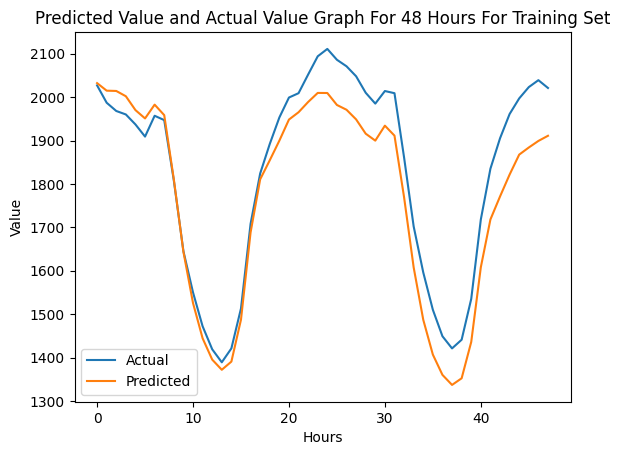

In [69]:
hours_to_predict = 48
start = random.randint(0, X_train.shape[0] - hours_to_predict - 1)


input = X_train[start]
future_data = X_train[start + 1: start + 1 + hours_to_predict, -1, 1:]

y_pred = recursiv_predict(model, input, future_data, device)
y_true = y_train[start:start + hours_to_predict]

y_pred = y_pred.detach().cpu().numpy()
y_true = y_true.detach().cpu().numpy()

y_pred = y_scalar.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
y_true = y_scalar.inverse_transform(y_true.reshape(-1, 1)).squeeze()

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f"Predicted Value and Actual Value Graph For {hours_to_predict} Hours For Training Set")
plt.xlabel("Hours")
plt.ylabel("Value")
plt.legend()

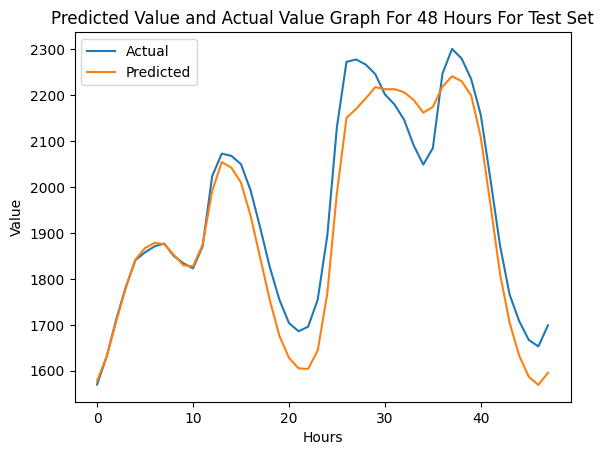

In [71]:
hours_to_predict = 48
start = random.randint(0, X_test.shape[0] - hours_to_predict - 1)


input = X_test[start]
future_data = X_test[start + 1: start + 1 + hours_to_predict, -1, 1:]

y_pred = recursiv_predict(model, input, future_data, device)
y_true = y_test[start:start + hours_to_predict]

y_pred = y_pred.detach().cpu().numpy()
y_true = y_true.detach().cpu().numpy()

y_pred = y_scalar.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
y_true = y_scalar.inverse_transform(y_true.reshape(-1, 1)).squeeze()

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f"Predicted Value and Actual Value Graph For {hours_to_predict} Hours For Test Set")
plt.xlabel("Hours")
plt.ylabel("Value")
plt.legend()

In [68]:
hours_to_predict = 48

samples = 500
errors = np.zeros((samples, ))

for i in range(samples):

    start = random.randint(0, X_test.shape[0] - hours_to_predict - 1)

    input = X_test[start]
    future_data = X_test[start + 1: start + 1 + hours_to_predict, -1, 1:]

    y_pred = recursiv_predict(model, input, future_data, device)
    y_true = y_test[start:start + hours_to_predict]

    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()

    y_pred = y_scalar.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
    y_true = y_scalar.inverse_transform(y_true.reshape(-1, 1)).squeeze()

    error = np.mean(np.abs((y_pred - y_true) / y_true) * 100)
    errors[i] = error

final_error = np.mean(errors)
print(f"Mean percentage error for test set when predicting for {hours_to_predict} hours is: {final_error:.2f}%")

Mean percentage error for test set when predicting for 48 hours is: 6.28%
